In [1]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

# from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

os.chdir("..")
from lib import *
import cv2

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K 

### 0. Literature review

Были проанализированны статьи:
- https://arxiv.org/pdf/1505.04597.pdf
- http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf

Испытана модель на основе VGG16 нейросети (1_Model)

И вручную составленная модель из последовательных слоев MaxPooling'а, а затем UpSampling'а (2_Model)

Но наиболее хорошие результаты удалось получить с помошью архитектуры U-Net (3_Model)

### 1. Get data into convenient format

In [3]:
images = os.listdir("data/train")
ids_train = [ind.split(".")[0] for ind in images]

rle_masks_train = [encode_rle(np.array(Image.open(f"data/train_mask/{ind}.png"))) for ind in ids_train]

df_train = pd.DataFrame({"img": images, "rle_mask": rle_masks_train})
#train_df.head()


val_images = os.listdir("data/valid/")
ids_val = [ind.split(".")[0] for ind in val_images]

rle_masks_val = [encode_rle(np.array(Image.open(f"data/valid_mask/{ind}.png"))) for ind in ids_val]

df_val = pd.DataFrame({"img": val_images, "rle_mask": rle_masks_val})
# val_df.head()


test_images = os.listdir("data/test/")
ids_test = [ind.split(".")[0] for ind in test_images]

df_test = pd.DataFrame({"img": test_images, "rle_mask": rle_masks_val[:len(test_images)]})
# val_df.head()

In [4]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join("data/train/", "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join("data/train_mask/", "{}.png".format(img_id)))
    

x_val_filenames = []
y_val_filenames = []
for img_id in ids_val:
    x_val_filenames.append(os.path.join("data/valid/", "{}.jpg".format(img_id)))
    y_val_filenames.append(os.path.join("data/valid_mask/", "{}.png".format(img_id)))


x_test_filenames = []
for img_id in ids_test:
    x_test_filenames.append(os.path.join("data/test/", "{}.jpg".format(img_id)))

In [5]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 1315
Number of validation examples: 145


### 2. Visualize

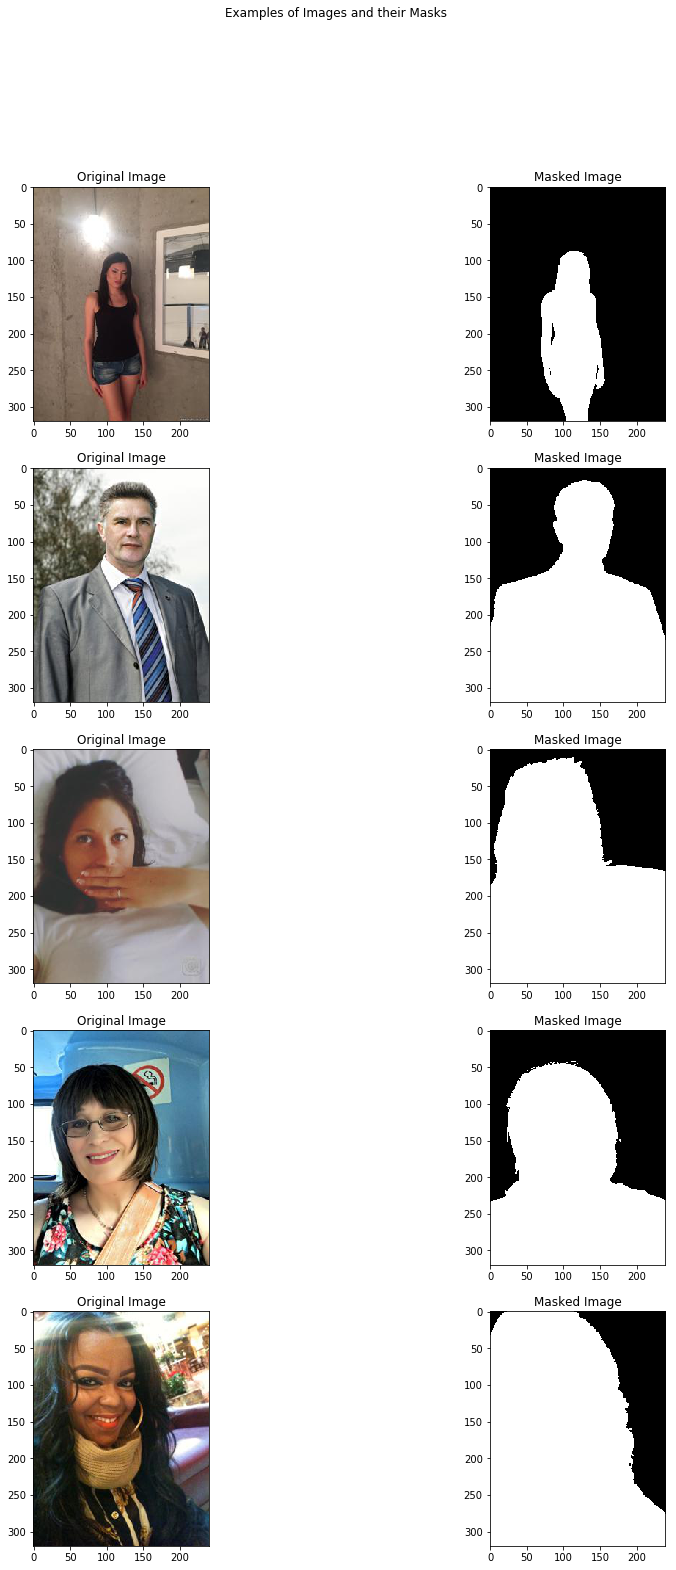

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(15, 25))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
  
    plt.subplot(display_num, 2, i + 1)
    plt.imshow(mpimg.imread(x_pathname))
    plt.title("Original Image")
  
    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)
    
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

### 3. Data augmentation

In [7]:
from augment import _augment, _process_pathnames, shift_img, flip_img


img_shape = (128, 128, 3)
batch_size = 3
epochs = 5

In [9]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
    if shuffle:
        dataset = dataset.shuffle(num_x)
  
  
    # It's necessary to repeat our data for all epochs 
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [10]:
tr_cfg = {
    'resize': [128, 128],
    #'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [11]:
val_cfg = {
    'resize': [128, 128],
    #'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [12]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)




Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


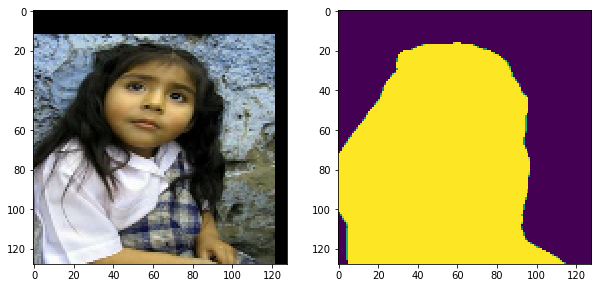

In [13]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    batch_of_imgs, label = sess.run(next_element)

    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0])
    plt.show()

### 4. Build the model

In [21]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [22]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [5]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [6]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [7]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [28]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        


In [14]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [30]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/5
438/439 [============================>.] - ETA: 0s - loss: 0.6576 - dice_loss: 0.2207
Epoch 00001: val_dice_loss improved from inf to 0.16611, saving model to /tmp/weights.hdf5
439/439 [==============================] - 239s 545ms/step - loss: 0.6571 - dice_loss: 0.2206 - val_loss: 0.7540 - val_dice_loss: 0.1661
Epoch 2/5
438/439 [============================>.] - ETA: 0s - loss: 0.5141 - dice_loss: 0.1706
Epoch 00002: val_dice_loss improved from 0.16611 to 0.14870, saving model to /tmp/weights.hdf5
439/439 [==============================] - 247s 562ms/step - loss: 0.5138 - dice_loss: 0.1705 - val_loss: 0.5248 - val_dice_loss: 0.1487
Epoch 3/5
438/439 [============================>.] - ETA: 0s - loss: 0.4410 - dice_loss: 0.1448
Epoch 00003: val_dice_loss improved from 0.14870 to 0.12212, saving model to /tmp/weights.hdf5
439/439 [==============================] - 246s 561ms/step - loss: 0.4405 - dice_loss: 0.1447 - val_loss: 0.3954 - val_dice_loss: 0.1221
Epoch 4/5
438/439 [=

### 5. Visualize training process

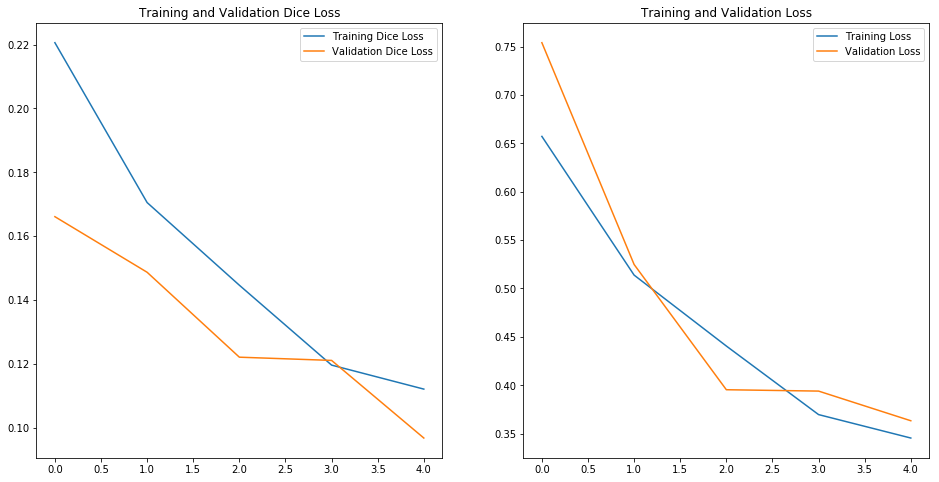

In [31]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [8]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


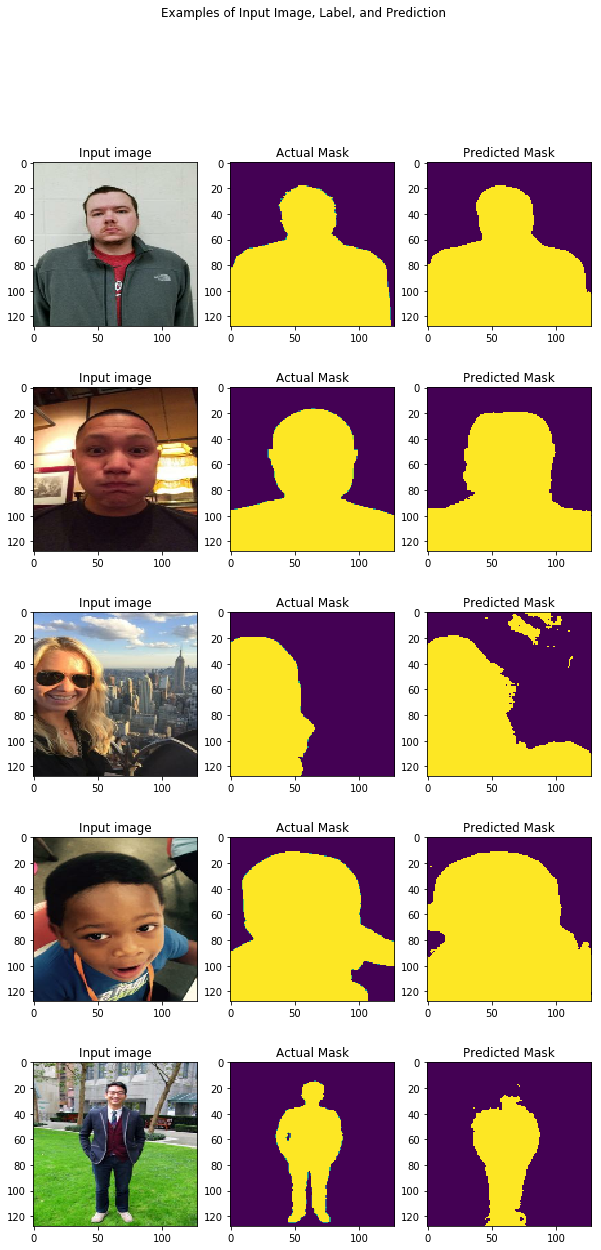

In [23]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]

    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")
  
    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[0, :, :, 0])
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label[:, :, 0] > 0.5)
    plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

### 6. Predict for val

In [37]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.iloc[i][0], gen_df.iloc[i][1]
            img = cv2.imread('data/valid/{}'.format(img_name))
            mask = decode_rle(mask_rle)
            
            
            img = cv2.resize(img, (128, 128))
            mask = cv2.resize(mask, (128, 128))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [38]:
for x, y in keras_generator(df_val, 145):
    break
    
pred = model.predict(x)

In [ ]:
pred_valid = pd.DataFrame({'id': ids_val, 
                           'rle_mask': [encode_rle(((cv2.resize(pred[i].reshape([128, 128]), (240, 320)) > 0.5) * 255.).astype(int)) for i in range(pred.shape[0])]})


pred_valid.to_csv('data/pred_valid_template.csv', sep=',', index=False)

pred_masks = [((cv2.resize(pred[i].reshape([128, 128]), (240, 320)) > 0.5) * 255.).astype(int) for i in range(pred.shape[0])]

pred_masks = [np.array(pred_masks[i], dtype = np.uint8) for i in range(pred.shape[0])]

_ = get_html(x_val_filenames, pred_masks, path_to_save="results/val")

### 7. Predict for test

In [24]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.iloc[i][0], gen_df.iloc[i][1]
            img = cv2.imread('data/test/{}'.format(img_name))
            
            
            img = cv2.resize(img, (128, 128))
            
            
            x_batch += [img]

        x_batch = np.array(x_batch) / 255.

        yield x_batch, np.expand_dims(y_batch, -1)

In [26]:
for x_test, y_test in keras_generator(df_test, df_test.shape[0]):
    break
    
pred_t = model.predict(x_test)

In [28]:
pred_test = pd.DataFrame({'id': ids_test, 
                           'rle_mask': [encode_rle(((cv2.resize(pred_t[i].reshape([128, 128]), (240, 320)) > 0.5) * 255.).astype(int)) for i in range(pred_t.shape[0])]})


pred_t_masks = [((cv2.resize(pred_t[i].reshape([128, 128]), (240, 320)) > 0.5) * 255.).astype(int) for i in range(pred_t.shape[0])]

pred_t_masks = [np.array(pred_t_masks[i], dtype = np.uint8) for i in range(pred_t.shape[0])]


_ = get_html(x_test_filenames, pred_t_masks, path_to_save="results/test")